Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Uploaded the dataset to kaggle

In [66]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

### Importing all the important libraries

In [67]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Using my custom Kaggle Dataset in the code

In [68]:
# Defining the path for train and test images
## paths of the train and test dataset
data_dir_train = pathlib.Path("/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [69]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful `image_dataset_from_directory`utility.

### Create a dataset

Define some parameters for the loader:

In [70]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [71]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                           image_size = (180, 180),
                                                           validation_split = 0.2,
                                                           subset = "training",seed=555,batch_size=32,labels='inferred',
                                                           color_mode = 'rgb',
                                                           shuffle = True)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [72]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                           image_size = (180, 180),
                                                           validation_split = 0.2,
                                                           subset = "validation",seed=555,batch_size=32,labels='inferred',
                                                           color_mode = 'rgb',
                                                           shuffle = True)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [73]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

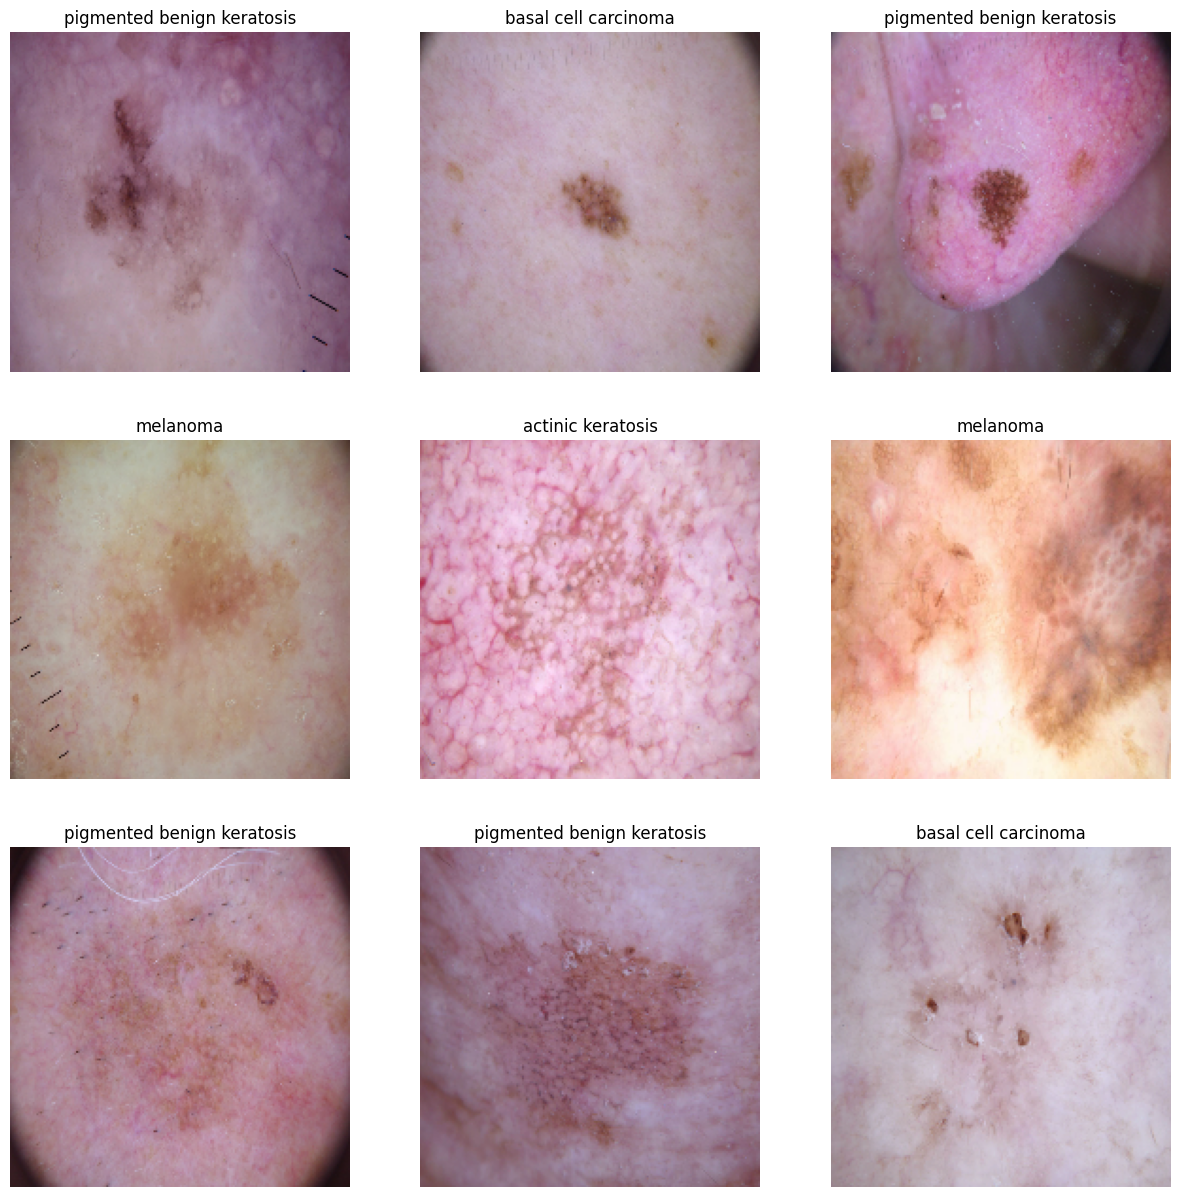

In [74]:
import matplotlib.pyplot as plt

# Fetch a batch of training images and labels
plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):  # .take(1) fetches one batch of data
    for i in range(9):  # To visualize 9 classes 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [75]:
def count_images_based_on_class(data_dir):

    count= []
    for path in pathlib.Path(data_dir).iterdir():
        if path.is_dir():

          count.append(len([name for name in os.listdir(path)
                if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in dir'])

In [76]:
count_images_based_on_class(data_dir_train)

,Class_Name,No.of Images in dir
0,pigmented benign keratosis,462
1,melanoma,438
2,vascular lesion,139
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,basal cell carcinoma,376
6,seborrheic keratosis,77
7,dermatofibroma,95
8,nevus,357


In [77]:
count_images_based_on_class(data_dir_test)

,Class_Name,No.of Images in dir
0,pigmented benign keratosis,16
1,melanoma,16
2,vascular lesion,3
3,actinic keratosis,16
4,squamous cell carcinoma,16
5,basal cell carcinoma,16
6,seborrheic keratosis,3
7,dermatofibroma,16
8,nevus,16


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [79]:
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, Flatten, Conv2D, Activation, MaxPooling2D, Rescaling
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator   
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense (9, activation='softmax'))


model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 83, 83, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 83, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 31, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844,169 (60.44 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

In [81]:
# Multi-class Classification
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

### Adding Early Stopping to reduce overfitting

In [82]:
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


In [129]:
def train_model(model,epochs=10, train_ds=train_ds, valid_ds=val_ds):
    return model.fit(train_ds, validation_data=valid_ds,
                    epochs=epochs,callbacks=[])


In [84]:
history = train_model(model, 20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.2111 - loss: 24.0669 - val_accuracy: 0.1991 - val_loss: 15.5424
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3753 - loss: 15.4113 - val_accuracy: 0.1700 - val_loss: 27.7088
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3683 - loss: 8.7818 - val_accuracy: 0.2506 - val_loss: 16.6293
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3518 - loss: 5.0748 - val_accuracy: 0.2170 - val_loss: 8.4759
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3844 - loss: 3.1196 - val_accuracy: 0.3356 - val_loss: 3.9366
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4012 - loss: 2.2147 - val_accuracy: 0.4027 - val_loss: 2.7406
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4795 - loss: 1.9763 - val_accuracy: 0.4072 - val_loss: 2.6133
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4718 - loss: 1.6963 - val_accuracy: 0.18

In [110]:
len(history.history['accuracy'])

12

### Util function for plotting training accuracy and loss

In [86]:
def plot_training_history(history, epochs = 10):
    """
    Plots the training and validation accuracy/loss for model history.

    Parameters:
    - history: the history object from a Keras model after training (history.history attribute should exist)
    - epochs: the number of epochs used during training (or total epochs to plot)
    """

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Creating ranges for each epoch
    epochs_range = range(epochs)

    # Plotting Training and Validation Accuracy and Loss
    plt.figure(figsize=(8, 8))

    # Training and Validation Accuracy (Left Subplot)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='lightblue')  # ⬅️ added color
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='orange')  # ⬅️ added color
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Training and Validation Loss (Right Subplot)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='lightgreen')  # ⬅️ added color
    plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='red')  # ⬅️ added color
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

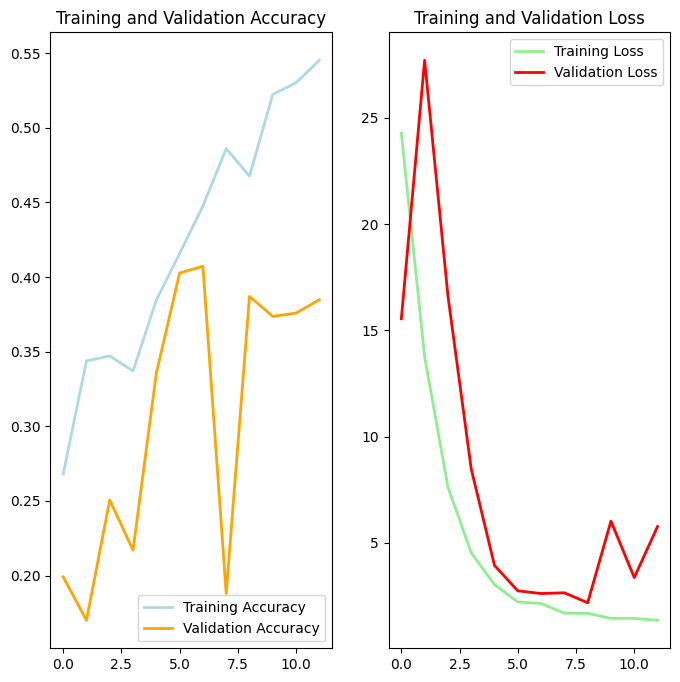

In [87]:
plot_training_history(history, len(history.history['accuracy']))

In [139]:
def calculate_metrics(model, train_ds=train_ds, valid_ds = val_ds):
    # Evaluating the model on the training dataset
    loss, accuracy = model.evaluate(train_ds, verbose=1)
    
    # Evaluating the model on the validation dataset
    loss_v, accuracy_v = model.evaluate(valid_ds, verbose=1)

    # Printing accurately with context
    print(f"🔹 **Training Accuracy:** {accuracy * 100:.2f}%")
    print(f"🔹 **Validation Accuracy:** {accuracy_v * 100:.2f}%")
    print(f"🔹 **Training Loss:** {loss:.4f}")
    print(f"🔹 **Validation Loss:** {loss_v:.4f}")

In [137]:
calculate_metrics(model,train_ds, valid_ds=val_ds)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 9)

### Visualizing training results

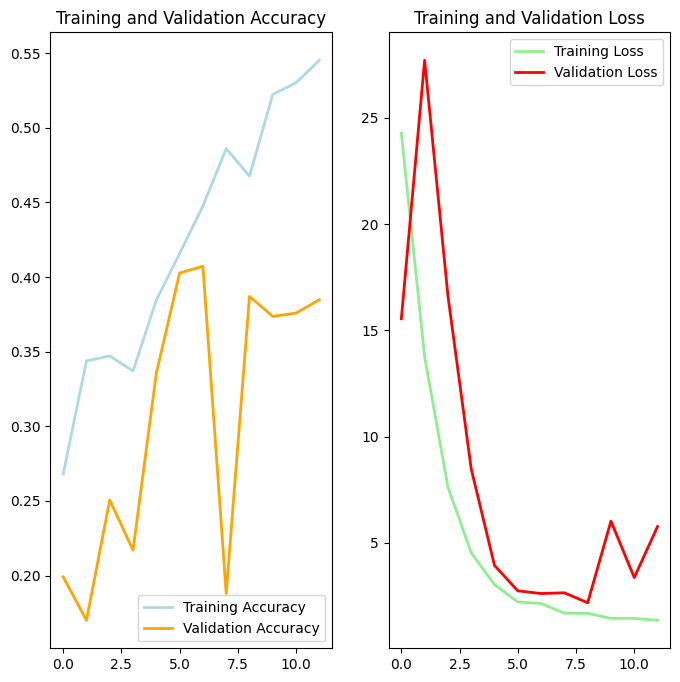

In [90]:
plot_training_history(history, len(history.history['accuracy']))

#### findings after the model fit, checking if there is an evidence of model overfit or underfit

Training accuracy of the model seems to increase linearly whereas validation accuracy remained stagnant around 55% High training accuracy means the model has learnt the noise in the data as well, however its poor performance on validation data shows lack of generalisability of the model. The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

In [97]:
# Analysed the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy. 


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [116]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
        'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
         'squamous cell carcinoma','vascular lesion']


In [123]:
training_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

validation_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [131]:

earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [132]:
history = train_model(model, 20, train_ds = training_batches, valid_ds=validation_batches)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4324 - loss: 2.3644 - val_accuracy: 0.1864 - val_loss: 16.3307
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 963ms/step - accuracy: 0.4266 - loss: 2.0403 - val_accuracy: 0.1441 - val_loss: 17.1710
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 949ms/step - accuracy: 0.4288 - loss: 1.8309 - val_accuracy: 0.2712 - val_loss: 3.1503
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 937ms/step - accuracy: 0.4639 - loss: 1.6594 - val_accuracy: 0.2034 - val_loss: 2.9636
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 932ms/step - accuracy: 0.4938 - loss: 1.4534 - val_accuracy: 0.1864 - val_loss: 3.5680
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 950ms/step - accuracy: 0.4721 - loss: 1.6133 - val_accuracy: 0.3136 - val_loss: 5.1128
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 942ms/step - accuracy: 0.4665 - loss: 1.5698 - val_accuracy: 0.2203 - val_loss: 3.0030
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 948ms/step - accuracy: 0.4741 - loss: 1.4769 - val_accuracy: 0.1780

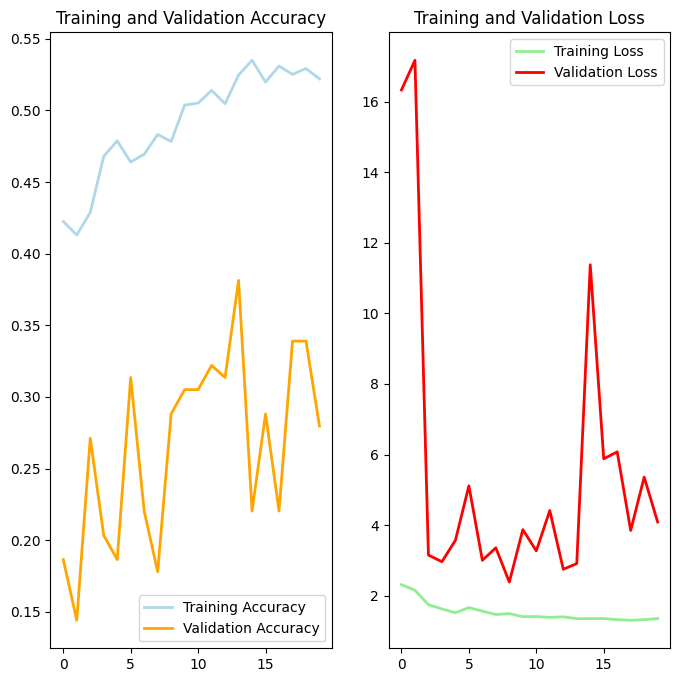

In [133]:
plot_training_history(history, len(history.history['accuracy']))

In [140]:
calculate_metrics(model, train_ds = training_batches, valid_ds=validation_batches)

35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 998ms/step - accuracy: 0.5190 - loss: 1.4351
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3197 - loss: 3.9113
🔹 **Training Accuracy:** 52.21%
🔹 **Validation Accuracy:** 33.90%
🔹 **Training Loss:** 1.4604
🔹 **Validation Loss:** 3.7573


### Augmentation

model performance is not improved. So the imbalanced dataset has to be balanced. using augumentations, increasing each class count to 500

In [92]:
# Vizualizing how your augmentation strategy works for one instance of training image.


In [141]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/output/*.jpg')))
print(image_count_train)

NameError: name 'train_dir' is not defined

In [93]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here



### Visualizing the results

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
import seaborn as sns


In [ ]:
plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
sns.barplot(x="No.of Images in train dir", y="Class_Name", data=df_train,
            label="Class_Name")
plt.subplot(2,1,2)
sns.barplot(x="No. of Images in test dir", y="Class_Name", data=df_test,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [144]:
!pip install Augmentor

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [146]:
import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
from pathlib import Path  # Import Path if not already imported
import Augmentor

# Assuming data_dir_train is a Path object and a directory containing class folders
path_to_training_dataset = data_dir_train  # Path() automatically handles slashes

# Define a base output directory where augmented files will be stored
output_dir = Path("/kaggle/working/augmented_output")  # Example: '/data/augmented_output'

for i in class_names:
    # Combine the class name with the training data directory
    class_path = path_to_training_dataset / i
    # Combine the class name with the output directory 
    class_output_path = output_dir / i  # Create an output subdirectory for each class

    # Ensure the output subdirectory exists (if not, create it)
    class_output_path.mkdir(parents=True, exist_ok=True)

    # Initialize the Augmentor pipeline
    p = Augmentor.Pipeline(str(class_path), output_directory=str(class_output_path))

    # Define augmentations and sample count
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Add 500 samples per class

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/augmented_output/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE3C7F4EEF0>: 100%|██████████| 500/500 [00:07<00:00, 67.75 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/augmented_output/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE4A5923B50>: 100%|██████████| 500/500 [00:06<00:00, 72.39 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/augmented_output/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE4A59C3D60>: 100%|██████████| 500/500 [00:06<00:00, 75.39 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/augmented_output/melanoma.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7EE4A5C59ED0>: 100%|██████████| 500/500 [00:33<00:00, 15.15 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/augmented_output/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7EE4A59C3F70>: 100%|██████████| 500/500 [00:29<00:00, 16.81 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/augmented_output/pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EE4A594E020>: 100%|██████████| 500/500 [00:05<00:00, 83.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/augmented_output/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE3606F0820>: 100%|██████████| 500/500 [00:16<00:00, 31.13 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/augmented_output/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE3606BAE30>: 100%|██████████| 500/500 [00:06<00:00, 82.79 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/augmented_output/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE3C411D0C0>:  28%|██▊       | 139/500 [00:01<00:04, 81.58 Samples/s]                  

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("/kaggle/working/model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

#### **Todo:**  Visualize the model results

In [ ]:
plot_training_history(history, len(history.history['accuracy']))

In [ ]:
calculate_metrics(model, train_ds, val_ds)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
import os            # Ensure os is imported for os.listdir
import pathlib       # Import pathlib module
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

### Predicting using the model on the test data

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
class_names=os.listdir('/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
class_num=2
Test_image_path = os.path.join(pathlib.Path(data_dir_test), class_names[class_num], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )